In [1]:
import requests
import time
import random
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Convert star symbols to float ratings
def convert_stars_to_float(star_text):
    if not star_text:
        return None
    half = '½' in star_text
    stars = star_text.count('★')
    return stars + 0.5 if half else stars

def get_earliest_release_date(movie_name):
    url = f"https://letterboxd.com/film/{movie_name}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch release page for {movie_name}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        release_table = soup.select_one('div.release-table.-bydate')
        if not release_table:
            print("No release table found.")
            return None

        first_date_el = release_table.select_one('h5.date')
        if not first_date_el:
            print("No date element found.")
            return None

        date_str = first_date_el.text.strip()
        release_date = pd.to_datetime(date_str, errors='coerce')
        print(f"Earliest release date for {movie_name}: {release_date.date()}")
        return release_date

    except Exception as e:
        print(f"Error parsing release date: {e}")
        return None

def get_reviews_from_page(url, release_date=None, latest_valid_date=None):
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch page: {url}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    review_elements = soup.select('article.production-viewing.-viewing')

    reviews_on_page = []
    now = pd.Timestamp.now().replace(tzinfo=None)
    earliest_valid = pd.Timestamp("1900-01-01")
    latest_valid = latest_valid_date or (now + pd.Timedelta(days=365 * 3))
    for review in review_elements:
        rating_el = review.select_one('span.rating')
        rating = convert_stars_to_float(rating_el.text.strip() if rating_el else None)

        date_el = review.select_one('time')
        raw_date_str = date_el['datetime'] if date_el else None

        try:
            date = pd.to_datetime(raw_date_str).replace(tzinfo=None)
            if not (earliest_valid <= date <= latest_valid):
                continue
            if release_date and date < release_date:
                continue
            if date > now:
                continue
        except:
            continue

        if rating is not None:
            reviews_on_page.append((date, rating))

    return reviews_on_page

def scrape_all_reviews(movie_name, base_urls):
    all_reviews = []
    release_date = get_earliest_release_date(movie_name)
    latest_valid_date = pd.Timestamp.now().replace(tzinfo=None) + pd.Timedelta(days=365 * 3)
    

    for base_url in base_urls:
        print(f'looking at {base_url}')
        bad_pages = 0
        page = 0
        if not base_url.endswith("/"):
            base_url += "/"

        while True:
            print(f'scraping page {page}')
            page_url = f"{base_url}page/{page}/"
            reviews = get_reviews_from_page(
                page_url,
                release_date=release_date,
                latest_valid_date=latest_valid_date
            )
            if reviews:
                all_reviews.extend(reviews)
            else:
                bad_pages += 1
            if bad_pages >= 5:
                break
            page += 4
            time.sleep(random.uniform(1, 2))

    return pd.DataFrame(all_reviews, columns=["date", "rating"])

def plot_review_data(df, movie_name):
    df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
    df['date'] = df['date'].dt.tz_localize(None)
    df = df.dropna(subset=['date'])
    df_sorted = df.sort_values('date')

    df_sorted['rolling_avg'] = df_sorted['rating'].rolling(window=50, min_periods=1).mean()

    x_numeric = mdates.date2num(df_sorted['date'])
    y = df_sorted['rating']

    slope, intercept = np.polyfit(x_numeric, y, 1)
    trendline = slope * x_numeric + intercept

    start_date = df_sorted['date'].iloc[0]
    end_date = df_sorted['date'].iloc[-1]
    start_pred = slope * mdates.date2num(start_date) + intercept
    end_pred = slope * mdates.date2num(end_date) + intercept

    plt.figure(figsize=(12, 6))
    plt.scatter(df_sorted['date'], df_sorted['rating'], alpha=0.5, label='Individual Ratings')
    plt.plot(df_sorted['date'], df_sorted['rolling_avg'], color='red', linewidth=2, label='Rolling Average (50 reviews)')
    plt.plot(df_sorted['date'], trendline, color='green', linestyle='--', linewidth=2, label='Trendline (Linear Fit)')

    plt.scatter([start_date], [start_pred], color='blue', zorder=5, label=f'Start: {start_pred:.2f}')
    plt.scatter([end_date], [end_pred], color='purple', zorder=5, label=f'End: {end_pred:.2f}')
    plt.text(start_date, start_pred + 0.1, f"{start_pred:.2f}", color='blue', ha='left', va='bottom')
    plt.text(end_date, end_pred + 0.1, f"{end_pred:.2f}", color='purple', ha='right', va='bottom')

    plt.title(f"{movie_name} — Ratings Over Time")
    plt.xlabel("Date")
    plt.ylabel("Rating")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.ylim(0, 5.5)
    plt.tight_layout()
    plt.show()




--- Processing the-dark-knight ---

Earliest release date for the-dark-knight: 2008-07-14
looking at https://letterboxd.com/film/the-dark-knight/reviews/by/added/
scraping page 0
scraping page 4
scraping page 8
scraping page 12
scraping page 16
scraping page 20
scraping page 24
scraping page 28
scraping page 32
scraping page 36
scraping page 40
scraping page 44
scraping page 48
scraping page 52
scraping page 56
scraping page 60
scraping page 64
scraping page 68
scraping page 72
scraping page 76
scraping page 80
scraping page 84
scraping page 88
scraping page 92
scraping page 96
scraping page 100
scraping page 104
scraping page 108
scraping page 112
scraping page 116
scraping page 120
scraping page 124
scraping page 128
scraping page 132
scraping page 136
scraping page 140
scraping page 144
scraping page 148
scraping page 152
scraping page 156
scraping page 160
scraping page 164
scraping page 168
scraping page 172
scraping page 176
scraping page 180
scraping page 184
scraping page 188


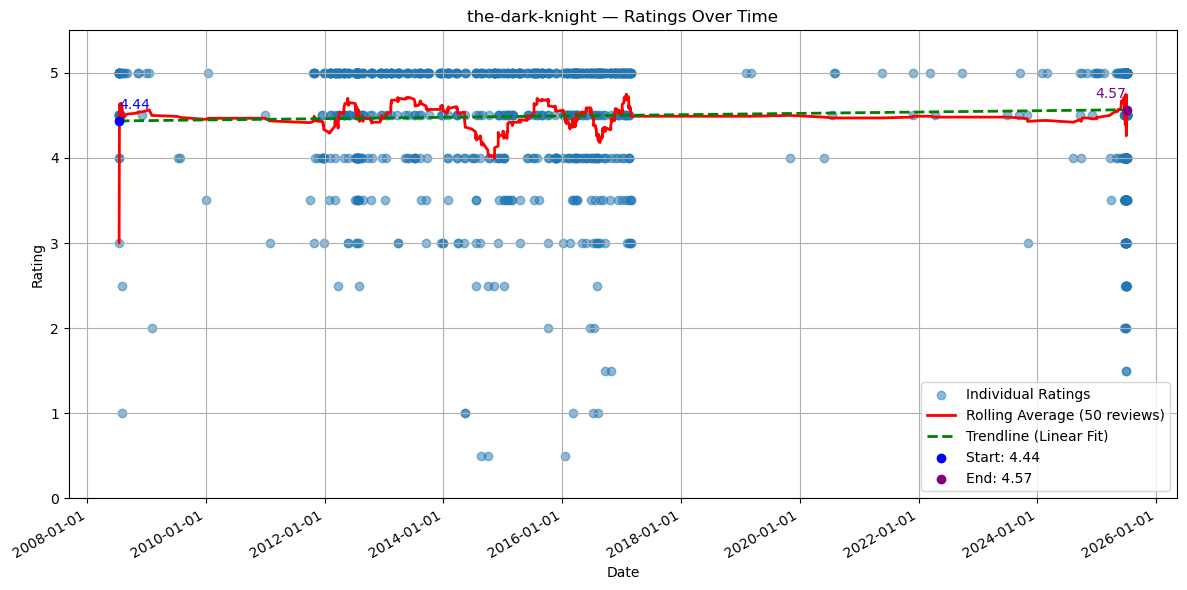


--- Processing freddy-got-fingered ---

Earliest release date for freddy-got-fingered: 2001-04-18
looking at https://letterboxd.com/film/freddy-got-fingered/reviews/by/added/
scraping page 0
scraping page 4
scraping page 8
scraping page 12
scraping page 16
scraping page 20
scraping page 24
scraping page 28
scraping page 32
scraping page 36
scraping page 40
scraping page 44
scraping page 48
scraping page 52
scraping page 56
scraping page 60
scraping page 64
scraping page 68
scraping page 72
scraping page 76
scraping page 80
scraping page 84
scraping page 88
scraping page 92
scraping page 96
scraping page 100
scraping page 104
scraping page 108
scraping page 112
scraping page 116
scraping page 120
scraping page 124
scraping page 128
scraping page 132
scraping page 136
scraping page 140
scraping page 144
scraping page 148
scraping page 152
scraping page 156
scraping page 160
scraping page 164
scraping page 168
scraping page 172
scraping page 176
scraping page 180
scraping page 184
scrapi

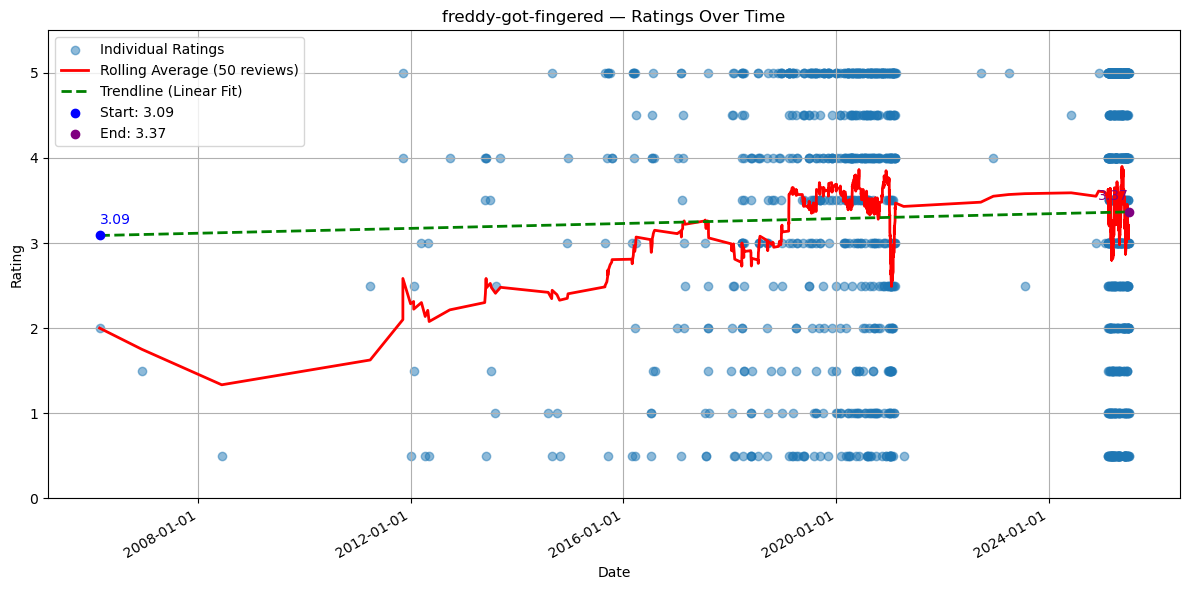


--- Processing macgruber ---

Earliest release date for macgruber: 2010-05-21
looking at https://letterboxd.com/film/macgruber/reviews/by/added/
scraping page 0
scraping page 4
scraping page 8
scraping page 12
scraping page 16
scraping page 20
scraping page 24
scraping page 28
scraping page 32
scraping page 36
scraping page 40
scraping page 44
scraping page 48
scraping page 52
scraping page 56
scraping page 60
scraping page 64
scraping page 68
scraping page 72
scraping page 76
scraping page 80
scraping page 84
scraping page 88
scraping page 92
scraping page 96
scraping page 100
scraping page 104
scraping page 108
scraping page 112
scraping page 116
scraping page 120
scraping page 124
scraping page 128
scraping page 132
scraping page 136
scraping page 140
scraping page 144
scraping page 148
scraping page 152
scraping page 156
scraping page 160
scraping page 164


In [ ]:
if __name__ == "__main__":
    movie_names = [
        "the-dark-knight",
        "freddy-got-fingered",
        "macgruber",
        "kinds-of-kindness",
        "annihilation",
        "the-lobster",
        "midsommar",
        "enter-the-void"
    ]

    for movie_name in movie_names:
        print(f"\n--- Processing {movie_name} ---\n")
        base_urls = [
            f"https://letterboxd.com/film/{movie_name}/reviews/by/added/",
            f"https://letterboxd.com/film/{movie_name}/reviews/by/added-earliest/"
        ]

        df = scrape_all_reviews(movie_name, base_urls)

        if df.empty:
            print(f"No reviews found for {movie_name}")
            continue

        print(f"Collected {len(df)} reviews for {movie_name}")
        plot_review_data(df, movie_name)
